(optgrowth)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`Optimal Growth I: The Stochastic Optimal Growth Model <single: Optimal Growth I: The Stochastic Optimal Growth Model>`

```{contents} Contents
:depth: 2
```

## Overview

In this lecture, we're going to study a simple optimal growth model with one
agent.

The model is a version of the standard one sector infinite horizon growth
model studied in

* {cite}`StokeyLucas1989`, chapter 2
* {cite}`Ljungqvist2012`, section 3.1
* [EDTC](http://johnstachurski.net/edtc.html), chapter 1
* {cite}`Sundaram1996`, chapter 12

It is an extension of the simple {doc}`cake eating problem <cake_eating_problem>` we looked at earlier.

The extension involves

* nonlinear returns to saving, through a production function, and
* stochastic returns, due to shocks to production.

Despite these additions, the model is still relatively simple.

We regard it as a stepping stone to more sophisticated models.

We solve the model using dynamic programming and a range of numerical
techniques.

In this first lecture on optimal growth, the solution method will be value
function iteration (VFI).

While the code in this first lecture runs slowly, we will use a variety of
techniques to drastically improve execution time over the next few lectures.

Let's start with some imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

## The Model

```{index} single: Optimal Growth; Model
```

Consider an agent who owns an amount $y_t \in \mathbb R_+ := [0, \infty)$ of a consumption good at time $t$.

This output can either be consumed or invested.

When the good is invested, it is transformed one-for-one into capital.

The resulting capital stock, denoted here by $k_{t+1}$, will then be used for production.

Production is stochastic, in that it also depends on a shock $\xi_{t+1}$ realized at the end of the current period.

Next period output is

$$
y_{t+1} := f(k_{t+1}) \xi_{t+1}
$$

where $f \colon \mathbb R_+ \to \mathbb R_+$ is called the production function.

The resource constraint is

```{math}
:label: outcsdp0

k_{t+1} + c_t \leq y_t
```

and all variables are required to be nonnegative.

### Assumptions and Comments

In what follows,

* The sequence $\{\xi_t\}$ is assumed to be IID.
* The common distribution of each $\xi_t$ will be denoted by $\phi$.
* The production function $f$ is assumed to be increasing and continuous.
* Depreciation of capital is not made explicit but can be incorporated into the production function.

While many other treatments of the stochastic growth model use $k_t$ as the state variable, we will use $y_t$.

This will allow us to treat a stochastic model while maintaining only one state variable.

We consider alternative states and timing specifications in some of our other lectures.

### Optimization

Taking $y_0$ as given, the agent wishes to maximize

```{math}
:label: texs0_og2

\mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right]
```

subject to

```{math}
:label: og_conse

y_{t+1} = f(y_t - c_t) \xi_{t+1}
\quad \text{and} \quad
0 \leq c_t \leq y_t
\quad \text{for all } t
```

where

* $u$ is a bounded, continuous and strictly increasing utility function and
* $\beta \in (0, 1)$ is a discount factor.

In {eq}`og_conse` we are assuming that the resource constraint {eq}`outcsdp0` holds with equality --- which is reasonable because $u$ is strictly increasing and no output will be wasted at the optimum.

In summary, the agent's aim is to select a path $c_0, c_1, c_2, \ldots$ for consumption that is

1. nonnegative,
1. feasible in the sense of {eq}`outcsdp0`,
1. optimal, in the sense that it maximizes {eq}`texs0_og2` relative to all other feasible consumption sequences, and
1. *adapted*, in the sense that the action $c_t$ depends only on
   observable outcomes, not on future outcomes such as $\xi_{t+1}$.

In the present context

* $y_t$ is called the *state* variable --- it summarizes the "state of the world" at the start of each period.
* $c_t$ is called the *control* variable --- a value chosen by the agent each period after observing the state.

### The Policy Function Approach

```{index} single: Optimal Growth; Policy Function Approach
```

One way to think about solving this problem is to look for the best **policy function**.

A policy function is a map from past and present observables into current action.

We'll be particularly interested in **Markov policies**, which are maps from the current state $y_t$ into a current action $c_t$.

For dynamic programming problems such as this one (in fact for any [Markov decision process](https://en.wikipedia.org/wiki/Markov_decision_process)), the optimal policy is always a Markov policy.

In other words, the current state $y_t$ provides a [sufficient statistic](https://en.wikipedia.org/wiki/Sufficient_statistic)
for the history in terms of making an optimal decision today.

This is quite intuitive, but if you wish you can find proofs in texts such as {cite}`StokeyLucas1989` (section 4.1).

Hereafter we focus on finding the best Markov policy.

In our context, a Markov policy is a function $\sigma \colon
\mathbb R_+ \to \mathbb R_+$, with the understanding that states are mapped to actions via

$$
c_t = \sigma(y_t) \quad \text{for all } t
$$

In what follows, we will call $\sigma$ a *feasible consumption policy* if it satisfies

```{math}
:label: idp_fp_og2

0 \leq \sigma(y) \leq y
\quad \text{for all} \quad
y \in \mathbb R_+
```

In other words, a feasible consumption policy is a Markov policy that respects the resource constraint.

The set of all feasible consumption policies will be denoted by $\Sigma$.

Each $\sigma \in \Sigma$ determines a [continuous state Markov process](https://python-advanced.quantecon.org/stationary_densities.html) $\{y_t\}$ for output via

```{math}
:label: firstp0_og2

y_{t+1} = f(y_t - \sigma(y_t)) \xi_{t+1},
\quad y_0 \text{ given}
```

This is the time path for output when we choose and stick with the policy $\sigma$.

We insert this process into the objective function to get

```{math}
:label: texss

\mathbb E
\left[ \,
\sum_{t = 0}^{\infty} \beta^t u(c_t) \,
\right] =
\mathbb E
\left[ \,
\sum_{t = 0}^{\infty} \beta^t u(\sigma(y_t)) \,
\right]
```

This is the total expected present value of following policy $\sigma$ forever,
given initial income $y_0$.

The aim is to select a policy that makes this number as large as possible.

The next section covers these ideas more formally.

### Optimality

The $\sigma$ associated with a given policy $\sigma$ is the mapping defined by

```{math}
:label: vfcsdp00

v_{\sigma}(y) =
\mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(\sigma(y_t)) \right]
```

when $\{y_t\}$ is given by {eq}`firstp0_og2` with $y_0 = y$.

In other words, it is the lifetime value of following policy $\sigma$
starting at initial condition $y$.

The **value function** is then defined as

```{math}
:label: vfcsdp0

v^*(y) := \sup_{\sigma \in \Sigma} \; v_{\sigma}(y)
```

The value function gives the maximal value that can be obtained from state $y$, after considering all feasible policies.

A policy $\sigma \in \Sigma$ is called **optimal** if it attains the supremum in {eq}`vfcsdp0` for all $y \in \mathbb R_+$.

### The Bellman Equation

With our assumptions on utility and production functions, the value function as defined in {eq}`vfcsdp0` also satisfies a **Bellman equation**.

For this problem, the Bellman equation takes the form

```{math}
:label: fpb30

v(y) = \max_{0 \leq c \leq y}
    \left\{
        u(c) + \beta \int v(f(y - c) z) \phi(dz)
    \right\}
\qquad (y \in \mathbb R_+)
```

This is a *functional equation in* $v$.

The term $\int v(f(y - c) z) \phi(dz)$ can be understood as the expected next period value when

* $v$ is used to measure value
* the state is $y$
* consumption is set to $c$

As shown in [EDTC](http://johnstachurski.net/edtc.html), theorem 10.1.11 and a range of other texts

> *The value function* $v^*$ *satisfies the Bellman equation*

In other words, {eq}`fpb30` holds when $v=v^*$.

The intuition is that maximal value from a given state can be obtained by optimally trading off

* current reward from a given action, vs
* expected discounted future value of the state resulting from that action

The Bellman equation is important because it gives us more information about the value function.

It also suggests a way of computing the value function, which we discuss below.

### Greedy Policies

The primary importance of the value function is that we can use it to compute optimal policies.

The details are as follows.

Given a continuous function $v$ on $\mathbb R_+$, we say that
$\sigma \in \Sigma$ is $v$-**greedy** if $\sigma(y)$ is a solution to

```{math}
:label: defgp20

\max_{0 \leq c \leq y}
    \left\{
    u(c) + \beta \int v(f(y - c) z) \phi(dz)
    \right\}
```

for every $y \in \mathbb R_+$.

In other words, $\sigma \in \Sigma$ is $v$-greedy if it optimally
trades off current and future rewards when $v$ is taken to be the value
function.

In our setting, we have the following key result

* A feasible consumption policy is optimal if and only if it is $v^*$-greedy.

The intuition is similar to the intuition for the Bellman equation, which was
provided after {eq}`fpb30`.

See, for example, theorem 10.1.11 of [EDTC](http://johnstachurski.net/edtc.html).

Hence, once we have a good approximation to $v^*$, we can compute the
(approximately) optimal policy by computing the corresponding greedy policy.

The advantage is that we are now solving a much lower dimensional optimization
problem.

### The Bellman Operator

How, then, should we compute the value function?

One way is to use the so-called **Bellman operator**.

(An operator is a map that sends functions into functions.)

The Bellman operator is denoted by $T$ and defined by

```{math}
:label: fcbell20_optgrowth

Tv(y) := \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int v(f(y - c) z) \phi(dz)
\right\}
\qquad (y \in \mathbb R_+)
```

In other words, $T$ sends the function $v$ into the new function
$Tv$ defined by {eq}`fcbell20_optgrowth`.

By construction, the set of solutions to the Bellman equation
{eq}`fpb30` *exactly coincides with* the set of fixed points of $T$.

For example, if $Tv = v$, then, for any $y \geq 0$,

$$
v(y)
= Tv(y)
= \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int v^*(f(y - c) z) \phi(dz)
\right\}
$$

which says precisely that $v$ is a solution to the Bellman equation.

It follows that $v^*$ is a fixed point of $T$.

### Review of Theoretical Results

```{index} single: Dynamic Programming; Theory
```

One can also show that $T$ is a contraction mapping on the set of
continuous bounded functions on $\mathbb R_+$ under the supremum distance

$$
\rho(g, h) = \sup_{y \geq 0} |g(y) - h(y)|
$$

See  [EDTC](http://johnstachurski.net/edtc.html), lemma 10.1.18.

Hence, it has exactly one fixed point in this set, which we know is equal to the value function.

It follows that

* The value function $v^*$ is bounded and continuous.
* Starting from any bounded and continuous $v$, the sequence $v, Tv, T^2v, \ldots$
  generated by iteratively applying $T$ converges uniformly to $v^*$.

This iterative method is called **value function iteration**.

We also know that a feasible policy is optimal if and only if it is $v^*$-greedy.

It's not too hard to show that a $v^*$-greedy policy exists
(see  [EDTC](http://johnstachurski.net/edtc.html), theorem 10.1.11 if you get stuck).

Hence, at least one optimal policy exists.

Our problem now is how to compute it.

### {index}`Unbounded Utility <single: Unbounded Utility>`

```{index} single: Dynamic Programming; Unbounded Utility
```

The results stated above assume that the utility function is bounded.

In practice economists often work with unbounded utility functions --- and so will we.

In the unbounded setting, various optimality theories exist.

Unfortunately, they tend to be case-specific, as opposed to valid for a large range of applications.

Nevertheless, their main conclusions are usually in line with those stated for
the bounded case just above (as long as we drop the word "bounded").

Consult,  for example, section 12.2 of [EDTC](http://johnstachurski.net/edtc.html), {cite}`Kamihigashi2012` or {cite}`MV2010`.

## Computation

```{index} single: Dynamic Programming; Computation
```

Let's now look at computing the value function and the optimal policy.

Our implementation in this lecture will focus on clarity and
flexibility.

Both of these things are helpful, but they do cost us some speed --- as you
will see when you run the code.

{doc}`Later <optgrowth_fast>` we will sacrifice some of this clarity and
flexibility in order to accelerate our code with just-in-time (JIT)
compilation.

The algorithm we will use is fitted value function iteration, which was
described in earlier lectures {doc}`the McCall model <mccall_fitted_vfi>` and
{doc}`cake eating <cake_eating_numerical>`.

The algorithm will be

(fvi_alg)=
1. Begin with an array of values $\{ v_1, \ldots, v_I \}$ representing
   the values of some initial function $v$ on the grid points $\{ y_1, \ldots, y_I \}$.
1. Build a function $\hat v$ on the state space $\mathbb R_+$ by
   linear interpolation, based on these data points.
1. Obtain and record the value $T \hat v(y_i)$ on each grid point
   $y_i$ by repeatedly solving {eq}`fcbell20_optgrowth`.
1. Unless some stopping condition is satisfied, set
   $\{ v_1, \ldots, v_I \} = \{ T \hat v(y_1), \ldots, T \hat v(y_I) \}$ and go to step 2.

### Scalar Maximization

To maximize the right hand side of the Bellman equation {eq}`fpb30`, we are going to use
the `minimize_scalar` routine from SciPy.

Since we are maximizing rather than minimizing, we will use the fact that the
maximizer of $g$ on the interval $[a, b]$ is the minimizer of
$-g$ on the same interval.

To this end, and to keep the interface tidy, we will wrap `minimize_scalar`
in an outer function as follows:

In [2]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

### Optimal Growth Model

We will assume for now that $\phi$ is the distribution of $\xi := \exp(\mu + s \zeta)$ where

* $\zeta$ is standard normal,
* $\mu$ is a shock location parameter and
* $s$ is a shock scale parameter.

We will store this and other primitives of the optimal growth model in a class.

The class, defined below, combines both parameters and a method that realizes the
right hand side of the Bellman equation {eq}`fpb30`.

In [3]:
class OptimalGrowthModel:

    def __init__(self,
                 u,            # utility function
                 f,            # production function
                 β=0.96,       # discount factor
                 μ=0,          # shock location parameter
                 s=0.1,        # shock scale parameter
                 grid_max=4,
                 grid_size=120,
                 shock_size=250,
                 seed=1234):

        self.u, self.f, self.β, self.μ, self.s = u, f, β, μ, s

        # Set up grid
        self.grid = np.linspace(1e-4, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))

    def state_action_value(self, c, y, v_array):
        """
        Right hand side of the Bellman equation.
        """

        u, f, β, shocks = self.u, self.f, self.β, self.shocks

        v = interp1d(self.grid, v_array)

        return u(c) + β * np.mean(v(f(y - c) * shocks))

In the second last line we are using linear interpolation.

In the last line, the expectation in {eq}`fcbell20_optgrowth` is
computed via [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_integration), using the approximation

$$
\int v(f(y - c) z) \phi(dz) \approx \frac{1}{n} \sum_{i=1}^n v(f(y - c) \xi_i)
$$

where $\{\xi_i\}_{i=1}^n$ are IID draws from $\phi$.

Monte Carlo is not always the most efficient way to compute integrals numerically
but it does have some theoretical advantages in the present setting.

(For example, it preserves the contraction mapping property of the Bellman operator --- see, e.g., {cite}`pal2013`.)

### The Bellman Operator

The next function implements the Bellman operator.

(We could have added it as a method to the `OptimalGrowthModel` class, but we
prefer small classes rather than monolithic ones for this kind of
numerical work.)

In [4]:
def T(v, og):
    """
    The Bellman operator.  Updates the guess of the value function
    and also computes a v-greedy policy.

      * og is an instance of OptimalGrowthModel
      * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)

    for i in range(len(grid)):
        y = grid[i]

        # Maximize RHS of Bellman equation at state y
        c_star, v_max = maximize(og.state_action_value, 1e-10, y, (y, v))
        v_new[i] = v_max
        v_greedy[i] = c_star

    return v_greedy, v_new

(benchmark_growth_mod)=
### An Example

Let's suppose now that

$$
f(k) = k^{\alpha}
\quad \text{and} \quad
u(c) = \ln c
$$

For this particular problem, an exact analytical solution is available (see {cite}`Ljungqvist2012`, section 3.1.2), with

```{math}
:label: dpi_tv

v^*(y) =
\frac{\ln (1 - \alpha \beta) }{ 1 - \beta} +
\frac{(\mu + \alpha \ln (\alpha \beta))}{1 - \alpha}
 \left[
     \frac{1}{1- \beta} - \frac{1}{1 - \alpha \beta}
 \right] +
 \frac{1}{1 - \alpha \beta} \ln y
```

and optimal consumption policy

$$
\sigma^*(y) = (1 - \alpha \beta ) y
$$

It is valuable to have these closed-form solutions because it lets us check
whether our code works for this particular case.

In Python, the functions above can be expressed as:

In [5]:

def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y



Next let's create an instance of the model with the above primitives and assign it to the variable `og`.

In [6]:
α = 0.4
def fcd(k):
    return k**α

og = OptimalGrowthModel(u=np.log, f=fcd)

Now let's see what happens when we apply our Bellman operator to the exact
solution $v^*$ in this case.

In theory, since $v^*$ is a fixed point, the resulting function should again be $v^*$.

In practice, we expect some small numerical error.

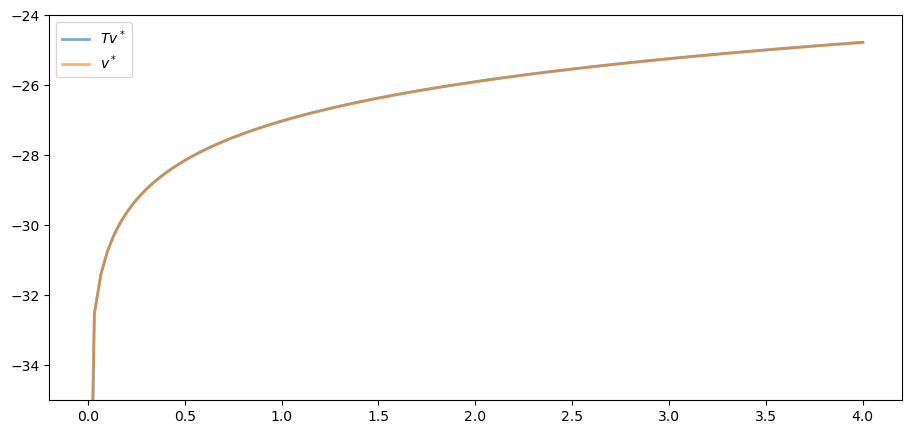

In [7]:
grid = og.grid

v_init = v_star(grid, α, og.β, og.μ)    # Start at the solution
v_greedy, v = T(v_init, og)             # Apply T once

fig, ax = plt.subplots()
ax.set_ylim(-35, -24)
ax.plot(grid, v, lw=2, alpha=0.6, label='$Tv^*$')
ax.plot(grid, v_init, lw=2, alpha=0.6, label='$v^*$')
ax.legend()
plt.show()

The two functions are essentially indistinguishable, so we are off to a good start.

Now let's have a look at iterating with the Bellman operator, starting
from an arbitrary initial condition.

The initial condition we'll start with is, somewhat arbitrarily, $v(y) = 5 \ln (y)$.

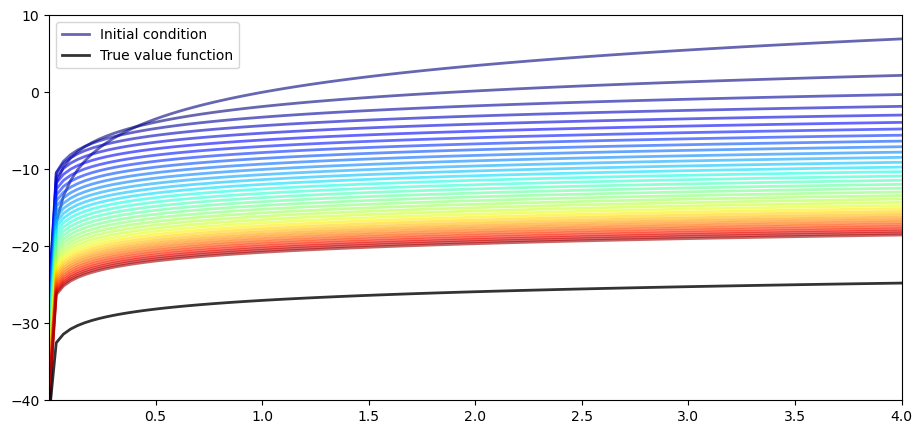

In [8]:
v = 5 * np.log(grid)  # An initial condition
n = 35

fig, ax = plt.subplots()

ax.plot(grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial condition')

for i in range(n):
    v_greedy, v = T(v, og)  # Apply the Bellman operator
    ax.plot(grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.plot(grid, v_star(grid, α, og.β, og.μ), 'k-', lw=2,
        alpha=0.8, label='True value function')

ax.legend()
ax.set(ylim=(-40, 10), xlim=(np.min(grid), np.max(grid)))
plt.show()

The figure shows

1. the first 36 functions generated by the fitted value function iteration algorithm, with hotter colors given to higher iterates
1. the true value function $v^*$ drawn in black

The sequence of iterates converges towards $v^*$.

We are clearly getting closer.

### Iterating to Convergence

We can write a function that iterates until the difference is below a particular
tolerance level.

In [9]:
def solve_model(og,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):
    """
    Solve model by iterating with the Bellman operator.

    """

    # Set up loop
    v = og.u(og.grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_greedy, v_new = T(v, og)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_greedy, v_new


Let's use this function to compute an approximate solution at the defaults.

In [10]:
v_greedy, v_solution = solve_model(og)

Error at iteration 25 is 0.40975776844490497.


Error at iteration 50 is 0.1476753540823772.


Error at iteration 75 is 0.05322171277213883.


Error at iteration 100 is 0.019180930548646558.


Error at iteration 125 is 0.006912744396029069.


Error at iteration 150 is 0.002491330384817303.


Error at iteration 175 is 0.000897867291303811.


Error at iteration 200 is 0.00032358842396718046.


Error at iteration 225 is 0.00011662020561331587.



Converged in 229 iterations.


Now we check our result by plotting it against the true value:

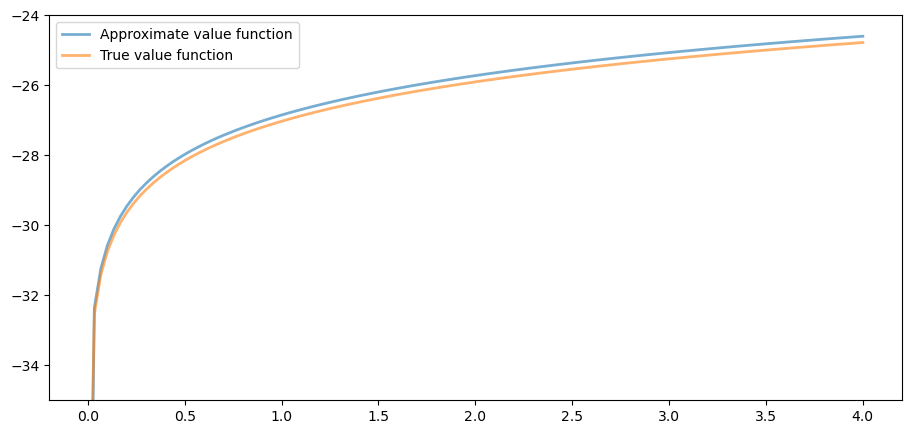

In [11]:
fig, ax = plt.subplots()

ax.plot(grid, v_solution, lw=2, alpha=0.6,
        label='Approximate value function')

ax.plot(grid, v_star(grid, α, og.β, og.μ), lw=2,
        alpha=0.6, label='True value function')

ax.legend()
ax.set_ylim(-35, -24)
plt.show()

The figure shows that we are pretty much on the money.

### The Policy Function

```{index} single: Optimal Growth; Policy Function
```

The policy `v_greedy` computed above corresponds to an approximate optimal policy.

The next figure compares it to the exact solution, which, as mentioned
above, is $\sigma(y) = (1 - \alpha \beta) y$

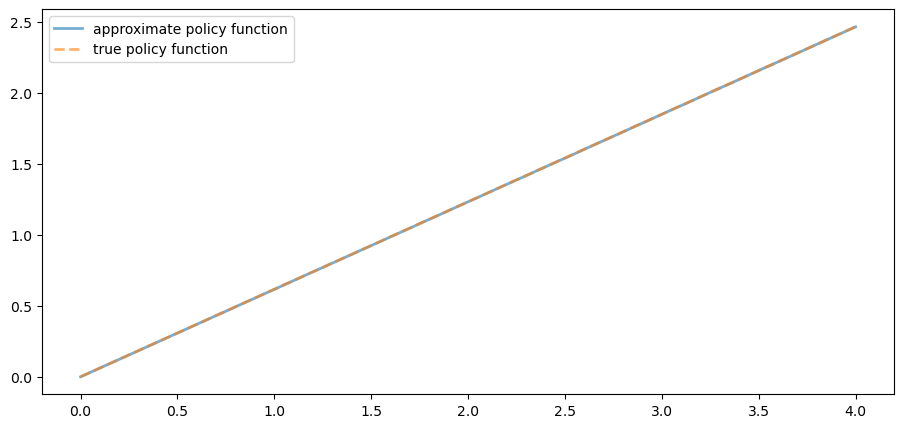

In [12]:
fig, ax = plt.subplots()

ax.plot(grid, v_greedy, lw=2,
        alpha=0.6, label='approximate policy function')

ax.plot(grid, σ_star(grid, α, og.β), '--',
        lw=2, alpha=0.6, label='true policy function')

ax.legend()
plt.show()

The figure shows that we've done a good job in this instance of approximating
the true policy.

## Exercises


```{exercise}
:label: og_ex1

A common choice for utility function in this kind of work is the CRRA
specification

$$
u(c) = \frac{c^{1 - \gamma}} {1 - \gamma}
$$

Maintaining the other defaults, including the Cobb-Douglas production
function,  solve the optimal growth model with this
utility specification.

Setting $\gamma = 1.5$, compute and plot an estimate of the optimal policy.

Time how long this function takes to run, so you can compare it to faster code developed in the {doc}`next lecture <optgrowth_fast>`.
```

```{solution-start} og_ex1
:class: dropdown
```

Here we set up the model.

In [13]:
γ = 1.5   # Preference parameter

def u_crra(c):
    return (c**(1 - γ) - 1) / (1 - γ)

og = OptimalGrowthModel(u=u_crra, f=fcd)

Now let's run it, with a timer.

In [14]:
%%time
v_greedy, v_solution = solve_model(og)

Error at iteration 25 is 0.5528151810417512.


Error at iteration 50 is 0.19923228425590978.


Error at iteration 75 is 0.07180266113800826.


Error at iteration 100 is 0.025877443335843964.


Error at iteration 125 is 0.009326145618970827.


Error at iteration 150 is 0.003361112262005861.


Error at iteration 175 is 0.0012113338243295857.


Error at iteration 200 is 0.0004365607333056687.


Error at iteration 225 is 0.00015733505506432266.



Converged in 237 iterations.
CPU times: user 48.3 s, sys: 124 ms, total: 48.4 s
Wall time: 48.1 s


Let's plot the policy function just to see what it looks like:

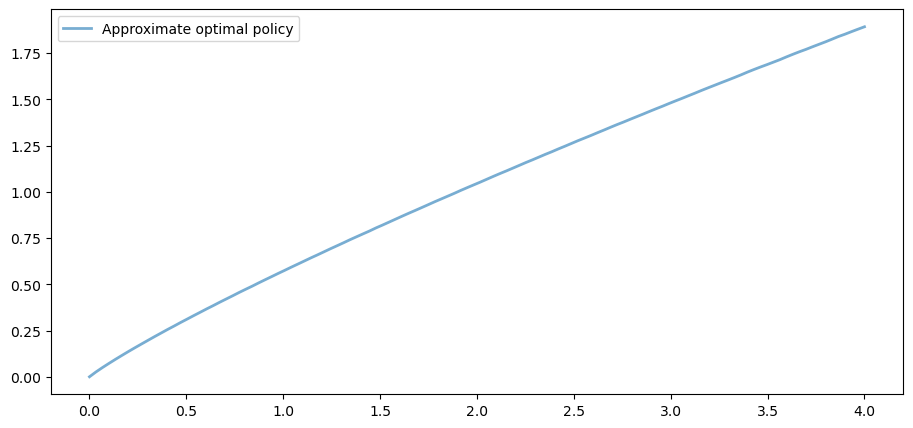

In [15]:
fig, ax = plt.subplots()

ax.plot(grid, v_greedy, lw=2,
        alpha=0.6, label='Approximate optimal policy')

ax.legend()
plt.show()

```{solution-end}
```

```{exercise}
:label: og_ex2

Time how long it takes to iterate with the Bellman operator
20 times, starting from initial condition $v(y) = u(y)$.

Use the model specification in the previous exercise.

(As before, we will compare this number with that for the faster code developed in the {doc}`next lecture <optgrowth_fast>`.)
```

```{solution-start} og_ex2
:class: dropdown
```

Let's set up:

In [16]:
og = OptimalGrowthModel(u=u_crra, f=fcd)
v = og.u(og.grid)

Here's the timing:

In [17]:
%%time

for i in range(20):
    v_greedy, v_new = T(v, og)
    v = v_new

CPU times: user 4.09 s, sys: 0 ns, total: 4.09 s
Wall time: 4.09 s


```{solution-end}
```